Автор: Лейман М.А.   
Дата создания: 28.04.2025  

# Задание ZALA  
## 4. Детектирование множества объектов
### ___Модель___ __MobileNet custom__   

#### ___Backbone___: MobileNet  
#### ___Детекция___: на выходе последнего слоя детекция  

Модель детектирует все объекты как один класс   

__Датасеты__: DOTA, UAVOD  
  


## Импорты

In [1]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import torch
from matplotlib import rcParams
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (14,6)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import random
from torch.utils.data import random_split
from PIL import ImageOps
from tqdm import tqdm


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/devsTraining/zala_task


## Проверка GPU

In [2]:
# Устанавливаем device:  gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Tue May 27 19:05:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
| 31%   51C    P5             23W /  170W |     888MiB /  12288MiB |     27%      Default |
|                                         

In [3]:
# Получаем текущую директорию
path_dir = os.getcwd()
print("Текущая директория:", path_dir)

DATA_DIR = os.path.abspath(os.path.join(path_dir, 'dataset'))
print("Путь к dataset:", DATA_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Текущая директория: /home/maksim/develops/python/devsTraining/zala_task
Путь к dataset: /home/maksim/develops/python/devsTraining/zala_task/dataset


 ## ДОП. ФУНКЦИИ

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageOps
import numpy as np
import torch


def draw_boxes(img_tensor, pred_tensor, true_tensor, S=16, B=2, C=1, threshold=0.5):
    """  
        Просмотр изображения в процессе валидации.
        Отрисовывает боксы предсказанные и реальные.
    """
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    h, w = img.shape[:2]

    # ===============     Карты уверенности 
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    gt_map = true_tensor[..., 4].cpu().numpy()
    im0 = axes[0].imshow(gt_map, cmap='hot', interpolation='nearest')
    axes[0].set_title("Target карта доверия")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    pred_map = np.zeros((S, S))
    for y in range(S):
        for x in range(S):
            for b in range(B):
                base = b * (5 + C)
                conf = pred_tensor[y, x, base + 4].item()
                pred_map[y, x] = max(pred_map[y, x], conf)

    im1 = axes[1].imshow(pred_map, cmap='hot', interpolation='nearest')
    axes[1].set_title("PRED карта доверия")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # ============    Отрисовка боксов 
    cell_size_x = w / S
    cell_size_y = h / S

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    for y in range(S):
        for x in range(S):
            # ============    GT боксы 
            for b in range(B):
                base = b * (5 + C)
                if true_tensor[y, x, base + 4] > 0:
                    tx, ty, tw, th = true_tensor[y, x, base:base+4]
                    abs_x = (x + tx.item()) * cell_size_x
                    abs_y = (y + ty.item()) * cell_size_y
                    abs_w = tw.item() * w
                    abs_h = th.item() * h
                    rect = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2),
                                             abs_w, abs_h,
                                             linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)

            # ============   Предсказанные боксы: только 1 с max confidence 
            best_conf = 0
            best_box = None
            for b in range(B):
                base = b * (5 + C)
                conf = pred_tensor[y, x, base + 4].item()
                if conf > best_conf and conf > threshold:
                    px, py, pw, ph = pred_tensor[y, x, base:base+4]
                    if not (0 <= px <= 1 and 0 <= py <= 1 and 0.01 <= pw <= 1.0 and 0.01 <= ph <= 1.0):
                        continue
                    best_conf = conf
                    best_box = (px.item(), py.item(), pw.item(), ph.item())

            if best_box:
                px, py, pw, ph = best_box
                abs_x = (x + px) * cell_size_x
                abs_y = (y + py) * cell_size_y
                abs_w = pw * w
                abs_h = ph * h

                if abs_w < 3 or abs_h < 3 or abs_w > w or abs_h > h:
                    continue

                rect = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2),
                                         abs_w, abs_h,
                                         linewidth=1.5, edgecolor='red', linestyle='--', facecolor='none')
                ax.add_patch(rect)
                ax.text(abs_x - abs_w / 2, abs_y - abs_h / 2 - 4,
                        f"{best_conf:.2f}", color='red', fontsize=8)

    # --- Сетка ---
    for i in range(1, S):
        ax.axhline(i * cell_size_y, color='gray', linestyle=':', linewidth=0.5)
        ax.axvline(i * cell_size_x, color='gray', linestyle=':', linewidth=0.5)

    plt.axis('off')
    plt.title("Green = Реальные, Red = Предсказанные")
    plt.show()



def yolo_collate_fn(batch):
    """  
        Функция объединения  для DataLoader.

        Принимает батч данных,  кортеж (изображение, таргеты),
        и объединяет их в батч-тензоры для обучения модели.

    Возвращает:
        imgs (Tensor): Батч изображений с формой [batch_size, C, H, W].
        targets (Tensor): Батч разметок с формой [batch_size, S, S, B*(5 + C)].
    """
    imgs = [img for img, target in batch]
    targets = [target for img, target in batch]

    imgs = torch.stack(imgs, dim=0)
    targets = torch.stack(targets, dim=0)  # [batch_size, S, S, 12]
    return imgs, targets




def resize_with_padding(img, desired_size=512):
    """  
        Меняет размер изображения
    """

    old_size = img.size  # (width, height)
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = img.resize(new_size, Image.BILINEAR)

    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)

    new_img = ImageOps.expand(img, padding, fill=(0, 0, 0))
    return new_img, ratio, padding


def extract_boxes(preds, targets, S, B, C, device):
    """  
        Извлекает предсказанные и истинные ограничивающие боксы (bounding boxes) из выходов YOLO и таргетов.

        Проходит по каждому элементу батча и по каждой ячейке сетки SxS. 
        Для каждого из B предсказанных боксов извлекает те, у которых в targets confidence > 0
        Возвращает пары (предсказанный бокс, истинный бокс) для  расчёта метрик.

    Аргументы:
        preds (Tensor): Предсказания модели формы [batch_size, S, S, B*(5+C)].
        targets (Tensor): Истинные значения формы [batch_size, S, S, B*(5+C)].
        S (int): Размер сетки (16).
        B (int): Количество предсказанных боксов на ячейку.
        C (int): Количество классов.
        device : Устройство, на которое перемещаются выходные тензоры.

    Возвращает:
        pred_boxes (Tensor): Предсказанные боксы, форма [N, 4], где N — количество найденных объектов.
        true_boxes (Tensor): Истинные боксы, форма [N, 4].
        Если объектов не найдено, возвращает (None, None).
    """


    batch_size = preds.size(0)
    pred_boxes = []
    true_boxes = []

    for i in range(batch_size):
        for y in range(S):
            for x in range(S):
                for b in range(B):
                    base = b * (5 + C)
                    if targets[i, y, x, base + 4] > 0:
                        pred_box = preds[i, y, x, base:base+4]
                        true_box = targets[i, y, x, base:base+4]
                        pred_boxes.append(pred_box)
                        true_boxes.append(true_box)

    if len(pred_boxes) == 0:
        return None, None

    pred_boxes = torch.stack(pred_boxes).to(device)
    true_boxes = torch.stack(true_boxes).to(device)

    return pred_boxes, true_boxes


## ДАТАСЕТ

In [5]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class YOLORealDataset(Dataset):
    """
    Кастомный PyTorch Dataset для загрузки изображений и аннотаций в формате YOLO.

    Параметры:
        images_path : str - Путь к директории с изображениями.
        
        labels_path : str - Путь к директории с аннотациями в формате YOLO (.txt файлы).
        
        S : int - Размер сетки (16),  для деления изображения на ячейки.
        
        B : int - Количество предсказываемых боксов на ячейку.
        
        C : int - Количество классов объектов.
        
        transform : torchvision.transforms или None  - Аугментации и преобразования, применяемые к изображениям.
        
        image_size : int - Размер изображения (ширина и высота) после изменения размера. По умолчанию 512.
    
    Атрибуты:
        image_files : list - Список имён файлов изображений.
        
        resize : torchvision.transforms.Resize -  Преобразование для изменения размера изображений.
    """

    def __init__(self, images_path, labels_path, S=16, B=2, C=1, transform=None, image_size=512):
        self.images_path = images_path
        self.labels_path = labels_path
        self.S = S
        self.B = B
        self.C = C
        self.transform = transform
        self.image_files = sorted(os.listdir(images_path))

        # Преобразование для изменения размера
        self.resize = T.Resize((image_size, image_size))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_name)
        label_path = os.path.join(self.labels_path, img_name.replace('.jpg', '.txt'))

        # Загружаем и ресайзим изображение
        img = Image.open(img_path).convert('RGB')
        img = self.resize(img)
        img = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).permute(2, 0, 1)

        # Загружаем аннотации
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                x_center, y_center, w, h = map(float, parts[1:])
                labels.append([cls, x_center, y_center, w, h])

        # Формируем target
        target = torch.zeros(self.S, self.S, self.B * (5 + self.C))
        for label in labels:
            cls, x_center, y_center, w, h = label
            grid_x = int(min(x_center * self.S, self.S - 1e-5))
            grid_y = int(min(y_center * self.S, self.S - 1e-5))

            for b in range(self.B):
                base = b * (5 + self.C)
                target[grid_y, grid_x, base + 0] = x_center * self.S - grid_x  # dx
                target[grid_y, grid_x, base + 1] = y_center * self.S - grid_y  # dy
                target[grid_y, grid_x, base + 2] = w
                target[grid_y, grid_x, base + 3] = h
                target[grid_y, grid_x, base + 4] = 1
                target[grid_y, grid_x, base + 5] = 1

        # target = target.unsqueeze(0)

        if self.transform:
            img = self.transform(img)

        return img, target


## МОДЕЛЬ

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class YOLOv2MobileNet(nn.Module):
    """
    Модель YOLOv2 на базе MobileNetV2 в качестве feature extractor-а.
    """

    def __init__(self, S=16, B=2, C=1):
        super(YOLOv2MobileNet, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        out_channels = B * (5 + C)

        # Загружаем MobileNetV2 без последнего классификатора
        mobilenet = models.mobilenet_v2(pretrained=True)

        self.features = mobilenet.features  # только сверточные слои MobileNet

        self.head = nn.Sequential(
            nn.Conv2d(1280, 512, 3, padding=1),  # MobileNetV2 заканчивается на 1280 каналов
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Conv2d(512, out_channels, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        x = x.permute(0, 2, 3, 1)

        B, S, _, _ = x.shape
        x = x.view(B, self.S, self.S, self.B, 5 + self.C)

        x[..., 0:2] = torch.sigmoid(x[..., 0:2])  # x, y
        x[..., 2:4] = torch.sigmoid(x[..., 2:4])  # w, h
        x[..., 4] = torch.sigmoid(x[..., 4])      # уверенность
        x[..., 5:] = torch.sigmoid(x[..., 5:])    # вероятность класса

        return x.view(B, self.S, self.S, -1)

    def initialize_weights(self):
        for m in self.head.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


## LOSS 

In [7]:
import torch.nn.functional as F

def yolo_loss(pred, target, S=16, B=2, C=3, lambda_coord=5, lambda_noobj=0.5):
    """
        Функция потерь для модели, вычисляющая общую потерю (loss) для каждой ячейки сетки.

    Параметры:
    pred : torch.Tensor - Тензор с предсказаниями модели, размерностью [Bath, S, S, B*(5 + C)],
        где:
            Bath — размер батча,
            S — размер сетки,
            5 — количество параметров для каждого бокса (x, y, w, h, уверенность),
            C — количество классов.
    
    target : torch.Tensor - Тензор с целевыми значениями, аналогичный размерности pred.
        
    S : int, по умолчанию 16 - Размер сетки, на которую разбивается изображение.
        
    B : int, по умолчанию 2 - Количество боксов, которые предсказываются для каждой ячейки.
        
    C : int, по умолчанию 3 - Количество классов, которые модель может предсказать.
        
    lambda_coord : float, по умолчанию 5 - Коэффициент для усиления потерь по координатам (x, y, w, h).
        
    lambda_noobj : float, по умолчанию 0.5 - Коэффициент для усиления потерь для ячеек, где нет объектов.

    Описание:
    Функция рассчитывает суммарную потерю для каждой ячейки сетки, используя несколько компонентов потерь:
    
        1. Потери по координатам (loss_coord):
                Рассчитываются только для ячеек, содержащих объект.
                Ошибка в координатах (x, y) и размерности бокса (w, h) с коэффициентом lambda_coord.

        2. Потери для объектов (loss_obj):
                Для ячеек, где присутствует объект, рассчитывается ошибка уверенности (confidence).

        3. Потери для отсутствия объектов (loss_noobj):
                Для ячеек, где нет объектов, рассчитывается ошибка уверенности с коэффициентом lambda_noobj.

        4. Потери для классов (loss_class):
                Для ячеек с объектами рассчитывается ошибка по классам (one-hot encoding).
       
    Все потери суммируются для получения общего значения потерь.

    Выход:
        Общая потеря для всего батча, нормализованная на размер батча.
    """

    mse = nn.MSELoss(reduction='sum')
    total_loss = 0.0

    for b in range(B):
        start = b * (5 + C) # Сдвиг бокса либо 0 либо 6

        # Маски start + 4 значение objectness уверенность, что в ячейке есть объект
        obj_mask = target[..., start + 4] > 0
        noobj_mask = target[..., start + 4] == 0

        # Координаты (только если есть объект) 
        pred_box = pred[..., start:start+4][obj_mask]
        target_box = target[..., start:start+4][obj_mask]

        if pred_box.numel() > 0:  # Если тензор не пуст
            loss_coord = lambda_coord * mse(pred_box, target_box)
        else:
            loss_coord = 0

    
        loss_obj = mse(pred[..., start + 4][obj_mask], target[..., start + 4][obj_mask])
        loss_noobj = lambda_noobj * mse(pred[..., start + 4][noobj_mask], target[..., start + 4][noobj_mask])

        # Классы (one-hot)
        pred_class = pred[..., start + 5:start + 5 + C][obj_mask]
        target_class = target[..., start + 5:start + 5 + C][obj_mask]

        if pred_class.numel() > 0:
            loss_class = mse(pred_class, target_class)
        else:
            loss_class = 0

        total_loss += loss_coord + loss_obj + loss_noobj + loss_class

    return total_loss / pred.shape[0]  # нормализуем на batch


## Метрика

In [8]:
def calculate_iou(box1, box2):  # не используется
    """
    Вычисляет IoU (Intersection over Union) между двумя bboxes (bounding boxes).
    
    Формат входа:
        box1, box2: Тензоры произвольной размерности с последним измерением 4
            (x_center, y_center, width, height) — YOLO-формат.
    
    Этапы:
        1. Преобразование центра и размеров в координаты углов (xmin, ymin, xmax, ymax).
        2. Вычисление координат пересечения (inter_x1, inter_y1, inter_x2, inter_y2).
        3. Площадь пересечения: ширина * высота.
        4. Площадь объединения: area1 + area2 - inter_area.
        5. Итоговое значение IoU = inter_area / union_area.

    Возвращает:
        IoU между каждым соответствующим парой box1 и box2.
    """
    # box: [x_center, y_center, w, h]
    x1_min = box1[..., 0] - box1[..., 2] / 2
    y1_min = box1[..., 1] - box1[..., 3] / 2
    x1_max = box1[..., 0] + box1[..., 2] / 2
    y1_max = box1[..., 1] + box1[..., 3] / 2

    x2_min = box2[..., 0] - box2[..., 2] / 2
    y2_min = box2[..., 1] - box2[..., 3] / 2
    x2_max = box2[..., 0] + box2[..., 2] / 2
    y2_max = box2[..., 1] + box2[..., 3] / 2

    inter_x1 = torch.max(x1_min, x2_min)
    inter_y1 = torch.max(y1_min, y2_min)
    inter_x2 = torch.min(x1_max, x2_max)
    inter_y2 = torch.min(y1_max, y2_max)

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = area1 + area2 - inter_area + 1e-6
    iou = inter_area / union_area
    return iou


def calculate_iou_batch(boxes_preds, boxes_labels):
    """
    Вычисляет IoU по батчу предсказанных и истинных боксов.
    
    Формат входа:
        boxes_preds: Tensor формы (N, 4) — предсказанные боксы.
        boxes_labels: Tensor формы (N, 4) — истинные боксы.
    Формат бокса: (x_center, y_center, width, height)

    Описание:
        1. Преобразует YOLO-формат (центр + размеры) в координаты углов (xmin, ymin, xmax, ymax).
        2. Рассчитывает пересечение по каждой координате.
        3. Площадь пересечения = ширина * высота, с clamp(0), чтобы избежать отрицательных значений.
        4. Вычисляет площади каждого бокса.
        5. IoU = пересечение / объединение (добавлен небольшой epsylon  для избежания деления на 0).
    
    Возвращает:
        Тензор размера (N,) — значения IoU для каждой пары предсказание/истина в батче.
    """


    box1_x1 = boxes_preds[..., 0] - boxes_preds[..., 2] / 2
    box1_y1 = boxes_preds[..., 1] - boxes_preds[..., 3] / 2
    box1_x2 = boxes_preds[..., 0] + boxes_preds[..., 2] / 2
    box1_y2 = boxes_preds[..., 1] + boxes_preds[..., 3] / 2

    box2_x1 = boxes_labels[..., 0] - boxes_labels[..., 2] / 2
    box2_y1 = boxes_labels[..., 1] - boxes_labels[..., 3] / 2
    box2_x2 = boxes_labels[..., 0] + boxes_labels[..., 2] / 2
    box2_y2 = boxes_labels[..., 1] + boxes_labels[..., 3] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union = box1_area + box2_area - intersection + 1e-6

    # Условия для IoU  
    iou = torch.zeros_like(box1_area)  # Инициализируем тензор IoU нулями  


    # Определяем случаи  
    # Если есть объекты в предсказаниях и истинных данных  
    mask_valid = (box1_area > 0) & (box2_area > 0)  
    iou[mask_valid] = intersection[mask_valid] / (union[mask_valid] + 1e-6)  

    # Если ни предсказанного, ни истинного бокса нет, устанавливаем IoU в 1  
    mask_no_boxes = (box1_area == 0) & (box2_area == 0)  
    iou[mask_no_boxes] = 1.0  

    # Если предсказанный бокс отсутствует, а истинный бокс есть, IoU = 0  
    mask_pred_box_absent = (box1_area == 0) & (box2_area > 0)  
    iou[mask_pred_box_absent] = 0.0  

    # Если истинный бокс отсутствует, а предсказанный бокс есть, IoU = 0  
    mask_true_box_absent = (box1_area > 0) & (box2_area == 0)  
    iou[mask_true_box_absent] = 0.0  

    return iou  



## ОБУЧЕНИЕ

In [9]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_epoch(model, loader, optimizer, loss_fn, device, S, B, C):
    """  
        Тренировка
    """
    model.train()
    total_loss = 0
    total_iou = 0
    iou_count = 0

    loop = tqdm(loader, desc="Тренировка", leave=False)
    for imgs, targets in loop:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        
        loss = loss_fn(preds, targets, S, B, C)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_boxes, true_boxes = extract_boxes(preds, targets, S, B, C, device)
        if pred_boxes is not None and true_boxes is not None:
            ious = calculate_iou_batch(pred_boxes, true_boxes)
            total_iou += ious.sum().item()
            iou_count += ious.numel()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / iou_count if iou_count > 0 else 0
    return avg_loss, avg_iou



@torch.no_grad()
def val_epoch(model, loader, loss_fn, device, S, B, C):
    """  
        Валидация
    """
    model.eval()
    total_loss = 0
    total_iou = 0
    iou_count = 0

    loop = tqdm(loader, desc="Валидация", leave=False)

    for imgs, targets in loop:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, targets, S, B, C)

        pred_boxes, true_boxes = extract_boxes(preds, targets, S, B, C, device)
        if pred_boxes is not None and true_boxes is not None:
            ious = calculate_iou_batch(pred_boxes, true_boxes)
            total_iou += ious.sum().item()
            iou_count += ious.numel()

        total_loss += loss.item()
        loop.set_postfix(val_loss=loss.item())

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / iou_count if iou_count > 0 else 0

    # Просмотр что получилось
    idx = random.randint(0, imgs.size(0) - 1)
    # print(preds[idx])
    # print(targets[idx][0][0])
    # print(targets[idx][1])
    clear_output(wait=True)
    draw_boxes(imgs[idx].cpu(), preds[idx].cpu(), targets[idx].cpu(), S, B, C)
    return avg_loss, avg_iou


def train_yolo(model, train_loader, val_loader, device, lr=0.001, epochs=10, S=16, B=2, C=1, save_path="models_custom/checkpoints", name_model="best_model.pth"):

    print("Использование устройства :", device)
    os.makedirs(save_path, exist_ok=True)
    train_losses = []
    val_losses = []
    val_ious = []
    train_ious = []
    patience = 10
    wait = 0
    best_val_loss = float("inf")

    lr_init = 0.001 
    optimizer = optim.Adam(model.parameters(), lr=lr_init)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(epochs):
        print(f"\n[Эпоха {epoch+1}/{epochs}]")

        train_loss, train_iou = train_epoch(model, train_loader, optimizer, yolo_loss, device, S, B, C)
        val_loss, val_iou = val_epoch(model, val_loader, yolo_loss, device, S, B, C)
        scheduler.step()

        print(f"Эпоха {epoch+1}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Train IoU={train_iou:.4f} | VAL IoU={val_iou:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)

            # =========   Сохраняем модель, если улучшение 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), os.path.join(save_path, name_model))
            print("Сохранена лучшая модель.")
        else:
            wait += 1
            print(f"Улучшений нет. Patience: {wait}/{patience}")
            if wait >= patience:
                print("Обучение остановлено.")
                break


    # Графики
    plt.figure(figsize=(12, 4))

    #  Train Val Loss 
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Train  Val IoU 
    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label='Train IoU', color='blue')
    plt.plot(val_ious, label='Val IoU', color='green')
    plt.title("IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()               



### Реальный датасет

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
import os 

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

current_directory = os.getcwd()  

img_size=512

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

path_dataset = os.path.join(current_directory, "dataset/dataset_full_3")

# Датасет  train
images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_train_1 = YOLORealDataset(
    images_path=path_image,
    labels_path=path_label,
    image_size=img_size
)


# Датасет  test
images_dir="images/test/"
targets_dir="labels/test/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_test = YOLORealDataset(
    images_path=path_image,
    labels_path=path_label,
    image_size=img_size
)


# Датасет  val
images_dir="images/val/"
targets_dir="labels/val/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_val = YOLORealDataset(
    images_path=path_image,
    labels_path=path_label,
    image_size=img_size
)


 # Датасет  train 2
path_dataset = os.path.join(current_directory, "dataset/dataset_full_4")
images_dir="images/train/"
targets_dir="labels/train/"
path_image = os.path.join(path_dataset, images_dir)
path_label = os.path.join(path_dataset, targets_dir)

dataset_train_2 = YOLORealDataset(
    images_path=path_image,
    labels_path=path_label,
    image_size=img_size
)


print("Пути к данным")
print(path_label)
print(path_image)

img, target = dataset_train_2[0]
print(img.shape)      # -> torch.Size([3, 512, 512])
print(target.shape)   # -> torch.Size([16, 16, 2 * (5 + 10)])




img, target = dataset_train_2[0]
print(img.shape)      # -> torch.Size([3, 512, 512])
print(target.shape)   # -> torch.Size([16, 16, 2 * (5 + 10)])


Пути к данным
/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_4/labels/train/
/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_full_4/images/train/
torch.Size([3, 512, 512])
torch.Size([16, 16, 12])
torch.Size([3, 512, 512])
torch.Size([16, 16, 12])


### Просмотр датасета

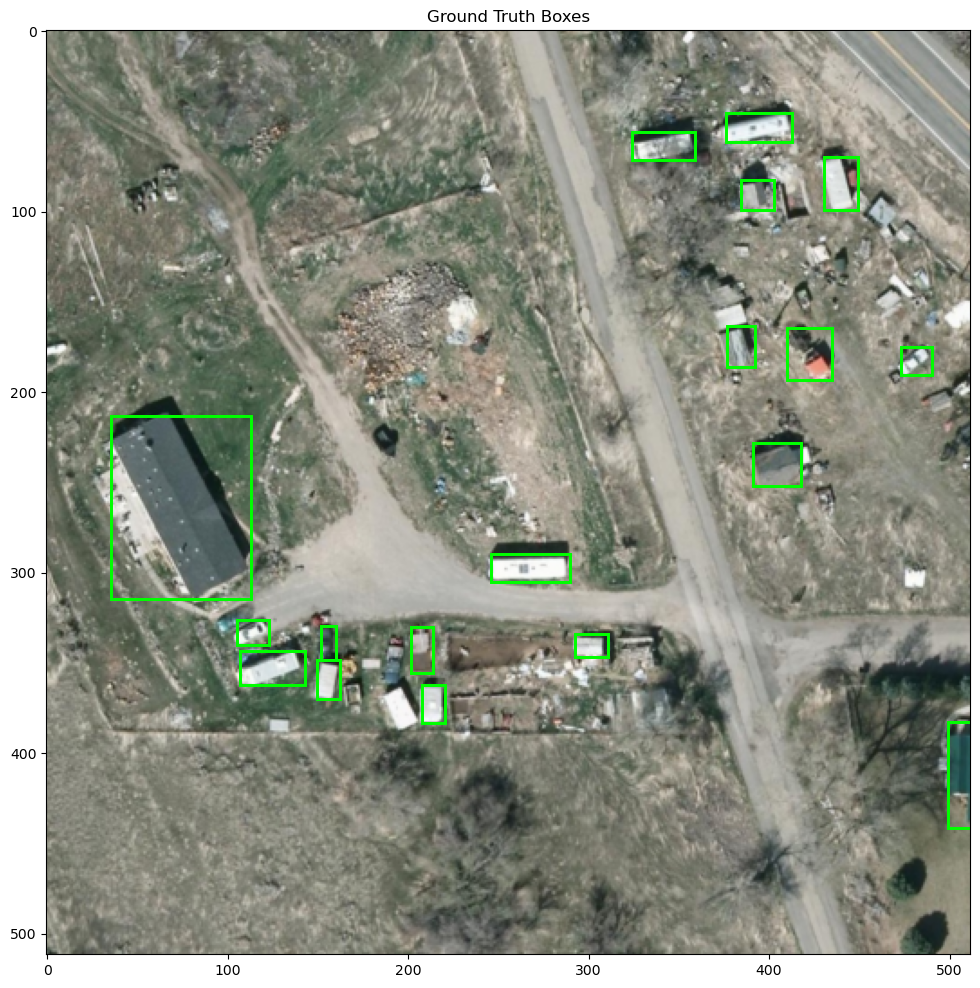

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torch.utils.data import DataLoader
from IPython.display import clear_output

def show_dataset(dataset, S=16, B=2, C=1, delay=2, batch_size=1):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=yolo_collate_fn)
    for imgs, targets in dataloader:
        for i in range(imgs.size(0)):
            img_tensor = imgs[i].cpu()
            true_tensor = targets[i].cpu()
            
            # print("БОКСЫ ", true_tensor[0])
            # print("min:", true_tensor.min().item())
            # print("max:", true_tensor.max().item())

            # Визуализация
            draw_gt_boxes(img_tensor, true_tensor, S=S, B=B, C=C)
            time.sleep(delay)
            clear_output(wait=True)
        break

def draw_gt_boxes(img_tensor, true_tensor, S=1, B=2, C=1):
    img = img_tensor.permute(1, 2, 0).numpy()
    h, w = img.shape[:2]

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)

    cell_size = w // S

    for y in range(S):
        for x in range(S):
            for b in range(B):
                base = b * (5 + C)
                if true_tensor[y, x, base + 4] > 0:
                    tx, ty, tw, th = true_tensor[y, x, base:base+4]
                    abs_x = (x + tx.item()) * cell_size
                    abs_y = (y + ty.item()) * cell_size
                    abs_w = tw.item() * w
                    abs_h = th.item() * h
                    rect = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2),
                                             abs_w, abs_h, linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)

    # plt.axis('off')
    plt.title("Ground Truth Boxes")
    plt.show()


show_dataset(dataset_train_1, S=16, B=2, C=1, delay=3)


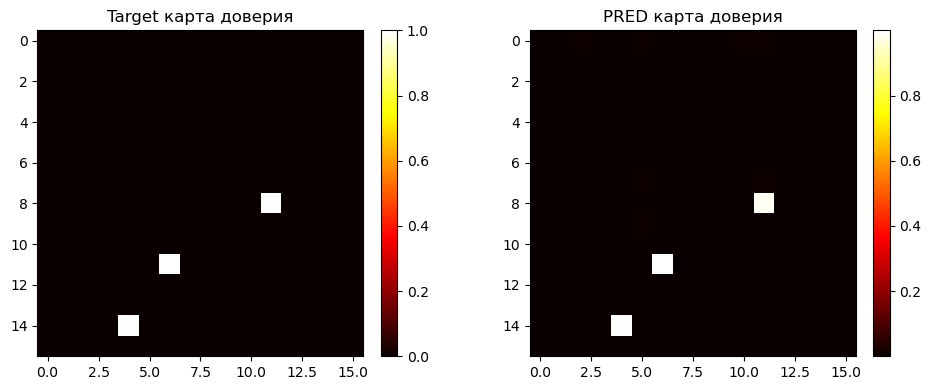

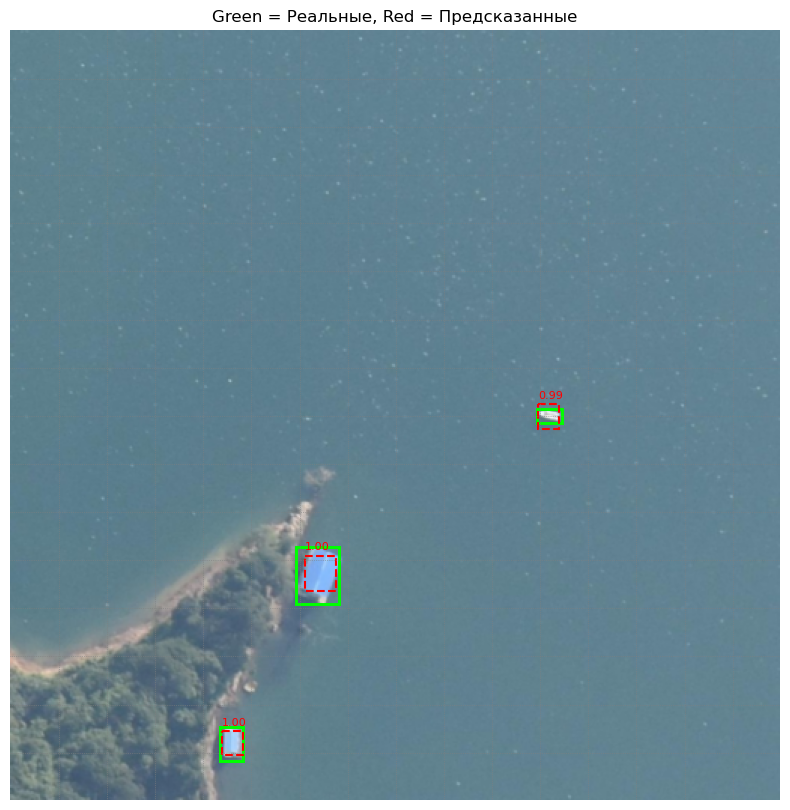

Эпоха 25: Train Loss=2.8698 | Val Loss=1.8399 | Train IoU=0.0760 | VAL IoU=0.0938
Сохранена лучшая модель.


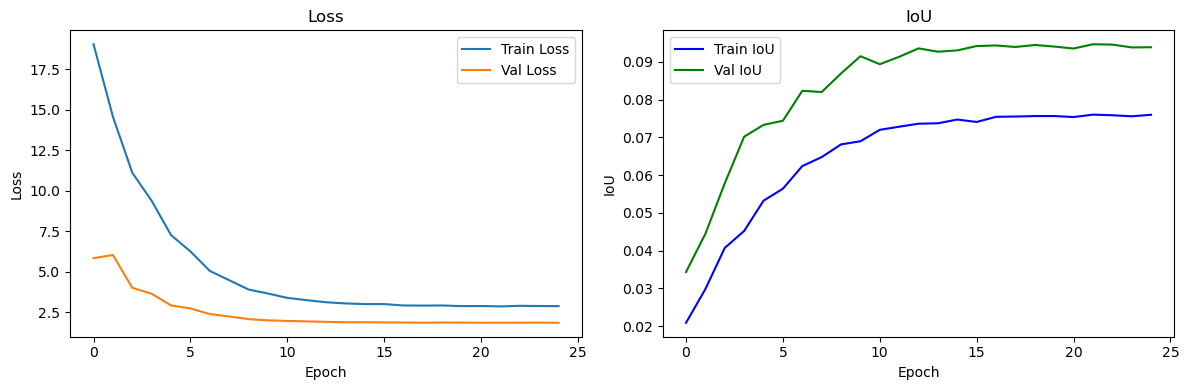

In [12]:
epochs=25
S=16
B=2
C=1
lr=0.0001
batch_size=16
save_path="models_custom/checkpoints"
name_model = "mobile_net_model_1.pth"
# dataset = YOLORealDataset(images_path=images_path, labels_path=labels_path, image_size=512)

# train_size = int(0.7 * len(dataset))
# val_size = len(dataset) - train_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(dataset_train_2, batch_size=batch_size, shuffle=True, collate_fn=yolo_collate_fn)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, collate_fn=yolo_collate_fn)

model_path = os.path.join(save_path, name_model)

model = YOLOv2MobileNet(S=S, B=B, C=C)


model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

tar = train_yolo(model, train_loader, val_loader, device, lr=lr, epochs=epochs, S=S, B=B, C=C, save_path=save_path, name_model=name_model)

## Сравнение

In [15]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.ops import nms
from PIL import Image
import os 

def inference_model(model, image_path, device, S=16, B=2, C=1, threshold=0.3, iou_thresh=0.3):
    model.eval()

    # ==============    Преобразование изображения 
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    # ===============   Предсказание 
    with torch.no_grad():
        preds = model(img_tensor)[0].cpu()  # (S, S, B*(5+C))

    img_np = img_tensor[0].permute(1, 2, 0).cpu().numpy()
    h, w = img_np.shape[:2]
    cell_size_x = w / S
    cell_size_y = h / S

    boxes = []
    confidences = []

    for y in range(S):
        for x in range(S):
            for b in range(B):
                base = b * (5 + C)
                conf = preds[y, x, base + 4].item()
                if conf < threshold:
                    continue

                px, py, pw, ph = preds[y, x, base:base+4]

                if not (0 <= px <= 1 and 0 <= py <= 1 and 0.01 <= pw <= 1.0 and 0.01 <= ph <= 1.0):
                    continue

                abs_x = (x + px) * cell_size_x
                abs_y = (y + py) * cell_size_y
                abs_w = pw * w
                abs_h = ph * h

                x1 = abs_x - abs_w / 2
                y1 = abs_y - abs_h / 2
                x2 = abs_x + abs_w / 2
                y2 = abs_y + abs_h / 2

                boxes.append([x1, y1, x2, y2])
                confidences.append(conf)

    if not boxes:
        print("Нет боксов выше порога.")
        return

    boxes = torch.tensor(boxes)
    scores = torch.tensor(confidences)

    keep = nms(boxes, scores, iou_thresh)

    # ===========    Отображение 
    fig, ax = plt.subplots(1, figsize=(16, 12))
    ax.imshow(img_np)

    for idx in keep:
        x1, y1, x2, y2 = boxes[idx]
        conf = scores[idx]

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{conf:.2f}", color='red', fontsize=9)

    ax.set_title("Найденные объекты")
    plt.axis('off')
    plt.show()


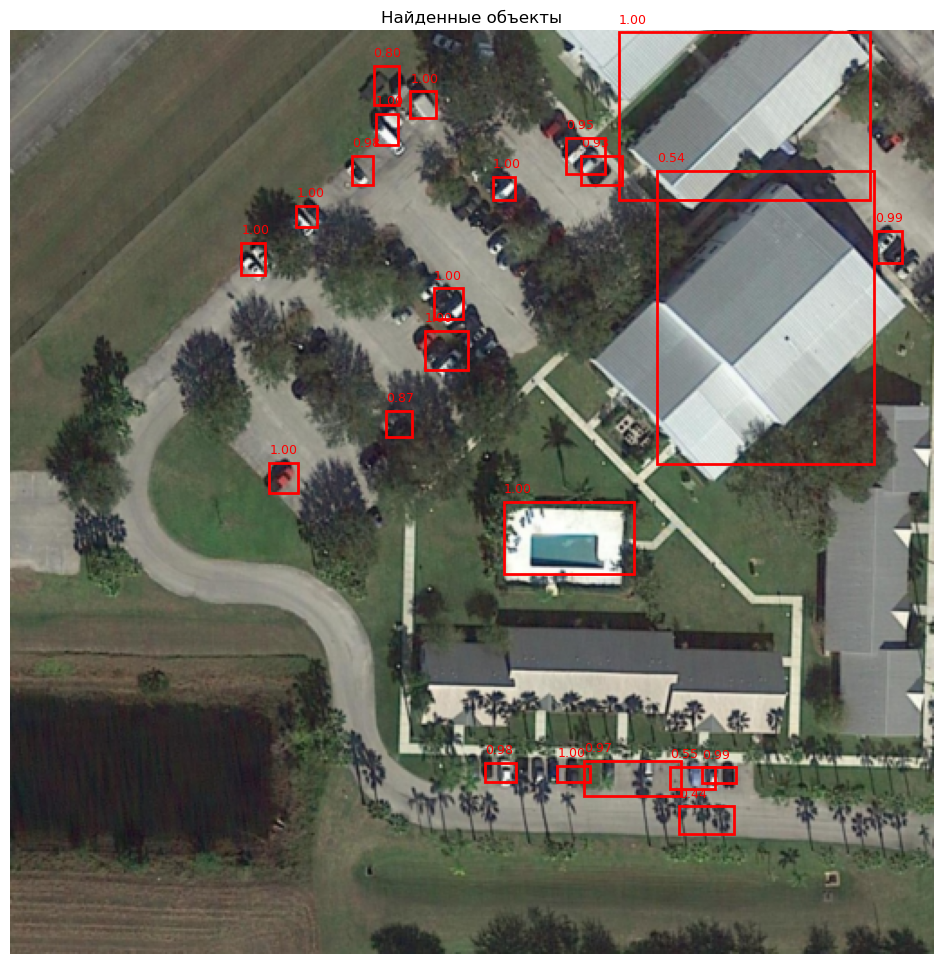

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_path="models_custom/checkpoints"
name_model = "mobile_net_model_1.pth"

model_path = os.path.join(save_path, name_model)

model = YOLOv2MobileNet(S=16, B=2, C=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


patch_image = "/home/maksim/develops/python/devsTraining/zala_task/dataset/TEST/images/P0179_0_crop8.jpg"

inference_model(model, patch_image, device, S=16, B=2, C=1, threshold=0.4)


## ПАРАМЕТРЫ МОДЕЛИ

In [ ]:
from ptflops import get_model_complexity_info


with torch.cuda.device(0):  
    macs, params = get_model_complexity_info(model, (3, 512, 512), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f'FLOPs: {macs}')
    print(f'Parameters: {params}')


FLOPs: 3.18 GMac
Parameters: 8.13 M


In [19]:
import torch.nn as nn



layer_count = sum(1 for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.ReLU6, nn.LeakyReLU,  nn.Dropout)))
print(f"Количество слоёв: {layer_count}")





layer_count = sum(1 for _ in model.modules())
print(f"Всего слоёв: {layer_count}")


Количество слоёв: 144
Всего слоёв: 216


In [21]:
from torchinfo import summary



summary(model, input_size=(1, 3, 512, 512))


Layer (type:depth-idx)                             Output Shape              Param #
YOLOv2MobileNet                                    [1, 16, 16, 12]           --
├─Sequential: 1-1                                  [1, 1280, 16, 16]         --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                            [1, 32, 256, 256]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 256, 256]         64
│    │    └─ReLU6: 3-3                             [1, 32, 256, 256]         --
│    └─InvertedResidual: 2-2                       [1, 16, 256, 256]         --
│    │    └─Sequential: 3-4                        [1, 16, 256, 256]         896
│    └─InvertedResidual: 2-3                       [1, 24, 128, 128]         --
│    │    └─Sequential: 3-5                        [1, 24, 128, 128]         5,136
│    └─InvertedResidual: 2-4                       [1, 24, 128, 128]         --
│    │    └─Sequential: 3-6   